<a href="https://colab.research.google.com/github/SadeemAlasiri/week7Ex/blob/main/Copy_of_Task2_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification Exam

Welcome to the Text Classification Practical Exam. In this exam, you will be tasked with building, training, and evaluating an NLP model to classify text data. You are provided with a labeled dataset containing both the text and its corresponding class labels.

Your objective is to develop a model that accurately predicts the class of the given text. Make sure to follow best practices in data preprocessing, model selection, and evaluation to achieve optimal results.

Good luck!
___

# Install and Import Needed Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
import re

In [4]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
from nltk.tokenize import word_tokenize

In [6]:
import string
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Download the Dataset

In [7]:
!kaggle datasets download -d khaledzsa/spam-messages


Dataset URL: https://www.kaggle.com/datasets/khaledzsa/spam-messages
License(s): unknown
  0% 0.00/213k [00:00<?, ?B/s]
100% 213k/213k [00:00<00:00, 26.1MB/s]


In [8]:
!unzip spam-messages.zip

Archive:  spam-messages.zip
  inflating: spam.csv                


# Data Exploration

Before diving into preprocessing and model building, it’s important to first explore the dataset to understand its structure, distribution, and key characteristics. This step will help you gain insights into the data and guide your decisions in subsequent steps. Here’s what to consider:

1. **Inspect the Data**:
   Start by looking at the first few rows of the dataset to get a sense of its structure. Check the columns, data types, and a few sample entries. This helps to ensure that the data is loaded correctly and gives you an initial overview of the content.

2. **Check for Missing Values**:
   Identify if there are any missing values in the dataset.

3. **Distribution of Labels**:
   Examine the distribution of the target labels (classes).

4. **Text Data Characteristics (Bonus)**:
   Analyze the length of the text data. It is useful to calculate the number of words or characters in each text sample to understand how long the texts are. This will help you set a suitable `max_length` for tokenization and padding later. You can plot a histogram of text lengths to visualize the distribution.

5. **Common Words and Vocabulary (Bonus)**:
   Explore the most frequent words in the text data.

In [9]:
df =pd.read_csv('/content/spam.csv')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5572 non-null   object
 1   label   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [11]:
df

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will Ì_ b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other s...",ham
5570,The guy did some bitching but I acted like i'd...,ham


In [100]:
df['text'].head(10)

,text
0,"Go until jurong point, crazy.. Available only ..."
1,Ok lar... Joking wif u oni...
2,Free entry in 2 a wkly comp to win FA Cup fina...
3,U dun say so early hor... U c already then say...
4,"Nah I don't think he goes to usf, he lives aro..."
5,FreeMsg Hey there darling it's been 3 week's n...
6,Even my brother is not like to speak with me. ...
7,As per your request 'Melle Melle (Oru Minnamin...
8,WINNER!! As a valued network customer you have...
9,Had your mobile 11 months or more? U R entitle...


In [101]:
df['label'].head(10)

,label
0,ham
1,ham
2,spam
3,ham
4,ham
5,spam
6,ham
7,ham
8,spam
9,spam


In [102]:
df['label'].value_counts()

,count
label,
ham,4825
spam,747


In [ ]:
# ham=0
#spam=1

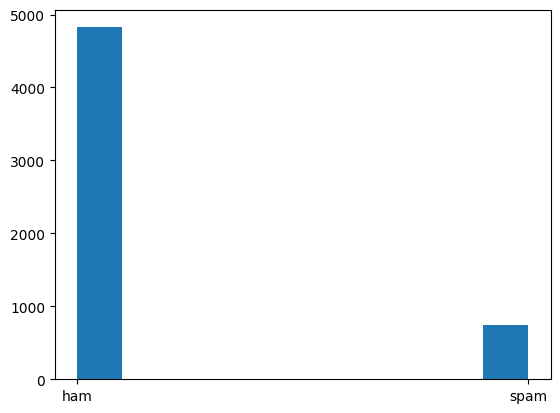

In [82]:
plt.hist(df['label'])
plt.show()

In [38]:
df.isna().sum()

,0
text,0
label,0


In [39]:
df.duplicated().sum()

183

        Word  Count
2144     com   2855
3969   https   2784
7760      to   2242
8613     you   2240
7631     the   1328
...      ...    ...
1793   bx526      1
1791      bx      1
1790      bw      1
1789  buzzzz      1
1785  buyers      1

[8676 rows x 2 columns]


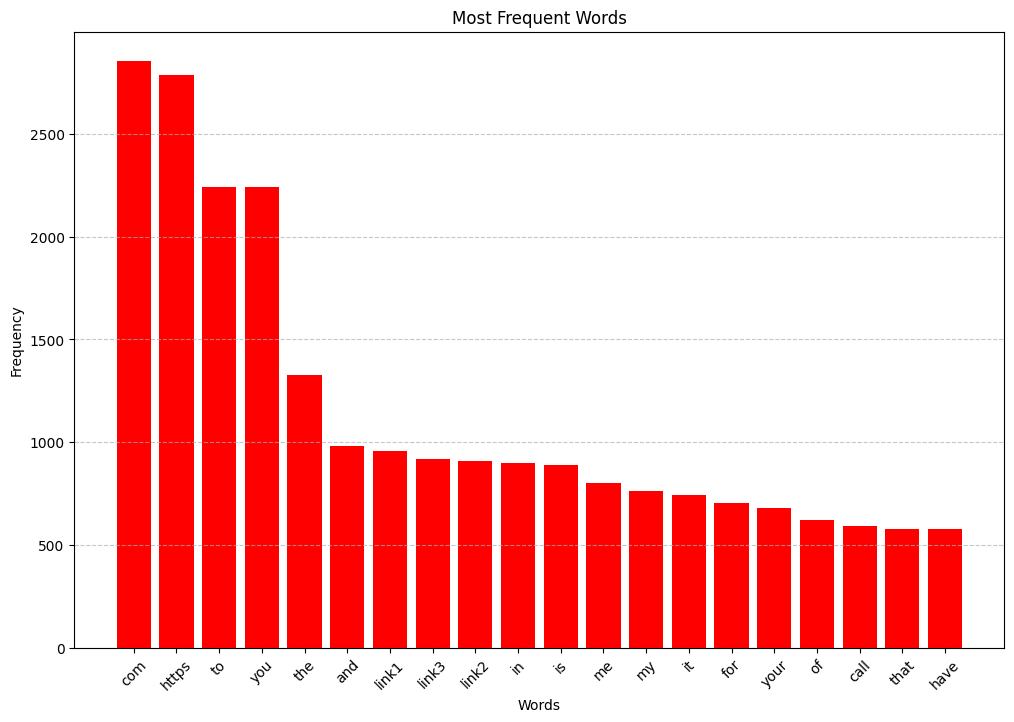

In [142]:
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df['text'])

words = vectorizer.get_feature_names_out()

word_counts = X.sum(axis=0).A1

word_counts_df = pd.DataFrame({'Word': words, 'Count': word_counts})
word_counts_df = word_counts_df.sort_values(by='Count', ascending=False)

print(word_counts_df)

plt.figure(figsize=(12, 8))
plt.bar(word_counts_df['Word'].head(20), word_counts_df['Count'].head(20), color='red')
plt.title('Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Data Cleaning and Preprocessing

In this section, we will focus on cleaning and filtering the dataset, preparing it for the text classification task. We will implement the following steps:

1. **Remove missing values**:  
   First, we eliminate any rows with missing values to ensure the dataset is complete and consistent.

2. **Filter by text length (Bonus)**:  
   To maintain a uniform dataset, we will filter the text samples by a specified word count range. This ensures that the texts are neither too short to lack context nor too long to introduce unnecessary complexity.

3. **English stopwords loading**:  
   We load a list of English stopwords to filter out commonly used but contextually insignificant words. This is an important step for improving the performance of the model, as stopwords do not contribute valuable information.

4. **Text cleaning**:  
   We apply a series of text cleaning steps to standardize and simplify the text data. This involves:
   
   - **Removing links (URLs)**:  
     Any URLs present in the text are removed as they are not meaningful for classification purposes.
   
   - **Removing special characters and punctuation**:  
     This step removes any non-alphabetical characters, ensuring the text only contains meaningful words.
   
   - **Lowercasing**:  
     All text is converted to lowercase for uniformity and to avoid case sensitivity issues.
   
   - **Removing English stopwords**:  
     Words that are part of the stopwords list are removed, as they do not add value to the classification task.
   
   - **Stemming or Lemmatization**:  
     Either stemming or lemmatization is applied to reduce words to their root or base form, ensuring consistency in word forms.

5. **Final cleanup**:
   Apply the cleanup function to the feature column.

By following these steps, the text will be cleaned, filtered, and ready for tokenization!

In [41]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [12]:
from string import punctuation

def clean_text(text):

    text = str(text).lower()

    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)

    text = re.sub('[%s]' % re.escape(punctuation), '', text)

    text = re.sub('\w*\d\w*', '', text)

    return ''.join(text)

In [13]:
df['clean_text'] = df['text'].apply(lambda x:clean_text(x))

df.head(10)

,text,label,clean_text
0,"Go until jurong point, crazy.. Available only ...",ham,go until jurong point crazy available only in ...
1,Ok lar... Joking wif u oni...,ham,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,free entry in a wkly comp to win fa cup final...
3,U dun say so early hor... U c already then say...,ham,u dun say so early hor u c already then say
4,"Nah I don't think he goes to usf, he lives aro...",ham,nah i dont think he goes to usf he lives aroun...
5,FreeMsg Hey there darling it's been 3 week's n...,spam,freemsg hey there darling its been weeks now ...
6,Even my brother is not like to speak with me. ...,ham,even my brother is not like to speak with me t...
7,As per your request 'Melle Melle (Oru Minnamin...,ham,as per your request melle melle oru minnaminun...
8,WINNER!! As a valued network customer you have...,spam,winner as a valued network customer you have b...
9,Had your mobile 11 months or more? U R entitle...,spam,had your mobile months or more u r entitled t...


In [14]:
df['text_list'] = df['clean_text'].apply(lambda x:word_tokenize(str(x)))
df.head()

,text,label,clean_text,text_list
0,"Go until jurong point, crazy.. Available only ...",ham,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,Ok lar... Joking wif u oni...,ham,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,free entry in a wkly comp to win fa cup final...,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,U dun say so early hor... U c already then say...,ham,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,"Nah I don't think he goes to usf, he lives aro...",ham,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."


In [15]:
def remove_stopword(word_list):
  return [word for word in word_list if word not in stopwords.words('english')]

df['text_list_without_sw'] = df['text_list'].apply(lambda x:remove_stopword(x))

In [147]:
df.head(10)

,text,label,clean_text,text_list,text_list_without_sw
0,"Go until jurong point, crazy.. Available only ...",ham,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n..."
1,Ok lar... Joking wif u oni...,ham,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,free entry in a wkly comp to win fa cup final...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,U dun say so early hor... U c already then say...,ham,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]"
4,"Nah I don't think he goes to usf, he lives aro...",ham,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t..."
5,FreeMsg Hey there darling it's been 3 week's n...,spam,freemsg hey there darling its been weeks now ...,"[freemsg, hey, there, darling, its, been, week...","[freemsg, hey, darling, weeks, word, back, id,..."
6,Even my brother is not like to speak with me. ...,ham,even my brother is not like to speak with me t...,"[even, my, brother, is, not, like, to, speak, ...","[even, brother, like, speak, treat, like, aids..."
7,As per your request 'Melle Melle (Oru Minnamin...,ham,as per your request melle melle oru minnaminun...,"[as, per, your, request, melle, melle, oru, mi...","[per, request, melle, melle, oru, minnaminungi..."
8,WINNER!! As a valued network customer you have...,spam,winner as a valued network customer you have b...,"[winner, as, a, valued, network, customer, you...","[winner, valued, network, customer, selected, ..."
9,Had your mobile 11 months or more? U R entitle...,spam,had your mobile months or more u r entitled t...,"[had, your, mobile, months, or, more, u, r, en...","[mobile, months, u, r, entitled, update, lates..."


In [148]:
df['text_list_without_sw'].head(20)

,text_list_without_sw
0,"[go, jurong, point, crazy, available, bugis, n..."
1,"[ok, lar, joking, wif, u, oni]"
2,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,"[u, dun, say, early, hor, u, c, already, say]"
4,"[nah, dont, think, goes, usf, lives, around, t..."
5,"[freemsg, hey, darling, weeks, word, back, id,..."
6,"[even, brother, like, speak, treat, like, aids..."
7,"[per, request, melle, melle, oru, minnaminungi..."
8,"[winner, valued, network, customer, selected, ..."
9,"[mobile, months, u, r, entitled, update, lates..."


In [16]:
df['text_clean_pro'] = df['text_list_without_sw'].apply(lambda words: ' '.join(words))

In [17]:
df

,text,label,clean_text,text_list,text_list_without_sw,text_clean_pro
0,"Go until jurong point, crazy.. Available only ...",ham,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...",go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ham,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]",ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,free entry in a wkly comp to win fa cup final...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...",free entry wkly comp win fa cup final tkts may...
3,U dun say so early hor... U c already then say...,ham,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]",u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",ham,nah i dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l...","[nah, dont, think, goes, usf, lives, around, t...",nah dont think goes usf lives around though
...,...,...,...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam,this is the time we have tried contact u u h...,"[this, is, the, time, we, have, tried, contact...","[time, tried, contact, u, u, å£, pound, prize,...",time tried contact u u å£ pound prize claim ea...
5568,Will Ì_ b going to esplanade fr home?,ham,will ì b going to esplanade fr home,"[will, ì, b, going, to, esplanade, fr, home]","[ì, b, going, esplanade, fr, home]",ì b going esplanade fr home
5569,"Pity, * was in mood for that. So...any other s...",ham,pity was in mood for that soany other suggest...,"[pity, was, in, mood, for, that, soany, other,...","[pity, mood, soany, suggestions]",pity mood soany suggestions
5570,The guy did some bitching but I acted like i'd...,ham,the guy did some bitching but i acted like id ...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, id, interested, b...",guy bitching acted like id interested buying s...


# Tokenization, Padding, and Data Splitting

In this step, we will prepare the text data for input into a model by converting the text into numerical sequences, padding them to a uniform length, and splitting the dataset into training and testing sets. Here's an overview of the steps involved:

1. **Tokenization**:
   We use a tokenizer to convert the cleaned text into numerical sequences. You can use `Tokenizer` tokenizer from `tensorflow.keras.preprocessing.text` package or any other tokenizer you like.

2. **Text to sequences**:
   After fitting the tokenizer on the cleaned text, we transform each text into a sequence of numbers, where each number corresponds to a token (word) in the text.

3. **Padding the sequences**:
   Since different texts may vary in length, we pad the sequences to ensure they all have the same length.

4. **Label encoding**:
   The labels (target values) also need to be converted into numerical form if they are not encoded.

5. **Train-test split**:
   The dataset is divided into training and testing sets. We allocate 80% of the data for training the model and reserve 20% for testing its performance.
   
   - The **training data** consists of the padded sequences used to train the model.
   - The **training labels** are the encoded labels corresponding to the training data.
   - The **testing data** is used to assess the model’s performance after training.
   - The **testing labels** are the encoded labels corresponding to the testing data.

6. **Data shape confirmation**:
   After splitting the data, we print the shape (dimensions) of both the training and testing sets to confirm that the data is properly divided and formatted.

By the end of this step, the text data will be transformed into padded numerical sequences, the labels will be encoded, and the data will be split into training and testing sets for model development and evaluation.

In [18]:
X = df['text_clean_pro']
y = df['label']


In [115]:
X

,text_clean_pro
0,go jurong point crazy available bugis n great ...
1,ok lar joking wif u oni
2,free entry wkly comp win fa cup final tkts may...
3,u dun say early hor u c already say
4,nah dont think goes usf lives around though
...,...
5567,time tried contact u u å£ pound prize claim ea...
5568,ì b going esplanade fr home
5569,pity mood soany suggestions
5570,guy bitching acted like id interested buying s...


In [19]:
print(X.shape)

(5572,)


In [117]:
y

,label
0,ham
1,ham
2,spam
3,ham
4,ham
...,...
5567,spam
5568,ham
5569,ham
5570,ham


In [118]:
print(y.shape)

(5572,)


In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
vectorizer = CountVectorizer()

X_array = np.array(X)

tokenized_X = vectorizer.fit_transform(X_array)

In [122]:
print(tokenized_X)

  (0, 2742)	1
  (0, 3591)	1
  (0, 5223)	1
  (0, 1486)	1
  (0, 464)	1
  (0, 898)	1
  (0, 2831)	1
  (0, 7864)	1
  (0, 3740)	1
  (0, 896)	1
  (0, 1210)	1
  (0, 2795)	1
  (0, 233)	1
  (0, 7637)	1
  (1, 4811)	1
  (1, 3776)	1
  (1, 3559)	1
  (1, 7765)	1
  (1, 4843)	1
  (2, 2542)	1
  (2, 2131)	2
  (2, 7818)	1
  (2, 1321)	1
  (2, 7779)	1
  (2, 2264)	2
  :	:
  (5568, 3115)	1
  (5568, 2758)	1
  (5568, 2529)	1
  (5568, 2159)	1
  (5569, 4420)	1
  (5569, 5162)	1
  (5569, 6359)	1
  (5569, 6724)	1
  (5570, 2542)	1
  (5570, 3255)	1
  (5570, 3886)	1
  (5570, 7682)	1
  (5570, 4620)	1
  (5570, 7437)	1
  (5570, 6383)	1
  (5570, 2075)	1
  (5570, 2659)	1
  (5570, 932)	1
  (5570, 3386)	1
  (5570, 2891)	1
  (5570, 59)	1
  (5570, 702)	1
  (5571, 4535)	1
  (5571, 7255)	1
  (5571, 5823)	1


In [22]:
tokenized_X_array = tokenized_X.toarray()

In [124]:
print(tokenized_X_array)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [23]:
X_pad_sequences = pad_sequences(tokenized_X_array,padding = 'post')
X_train , X_test = X_pad_sequences[:int(len(X_pad_sequences)*0.8)], X_pad_sequences[int(len(X_pad_sequences)*0.2):]

In [27]:
X_pad_sequences

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [28]:
print(X_pad_sequences.shape)

(5572, 8073)


In [132]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [138]:
X_train.shape

(4457, 200)

In [24]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

In [128]:
print(y)

[0 0 1 ... 0 0 0]


In [25]:
y_train, y_test  = y[:int(len(X_pad_sequences)*0.8)], y[int(len(X_pad_sequences)*0.2):]

In [137]:
print(y_train)

[0 0 1 ... 0 0 0]


In [139]:
y_train.shape

(4457,)

In [26]:
print(len(vectorizer.get_feature_names_out()))

8073


# Building the Classifier

In this step, you will design and build a NLP Classifier model to classify text data. Below is a breakdown of the key components you'll implement, but it's up to you to decide how to configure them based on your understanding and experimentation:

1. **Model Type**:
   You will use a Sequential model, which allows you to stack layers in a linear sequence.

2. **Input Layer**:
   Define the shape of the input data. Consider the dimensions of your padded sequences and set the input shape accordingly.

3. **Embedding Layer**:
   The embedding layer will convert input tokens (integers) into dense vector representations. You will need to determine the size of the input dimension (based on your vocabulary) and the output dimension (embedding size).

4. **Bidirectional Simple RNN/LSTM Layers**:
   You can add one or more recurrent layers. Consider using Bidirectional layers to capture contextual information from both directions (forward and backward). You can chose SimpleRNN/GRU/LSTM to perform this step.

5. **Dense Layers**:
   Add one or more fully connected (Dense) layers to process the output from the RNN/GRU/LSTM layers.

6. **Output Layer**:
   The output layer should match the type of classification task you're working on. Consider using appropriate activation function with appropriate number of units.

7. **Model Summary**:
   After defining your model architecture, print a summary to review the number of layers, types of layers, and total parameters.

8. **Model Compilation**:
   Finally, compile the model by selecting an optimizer, a loss function, and metrics.

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding , Dense
from tensorflow.keras.models import Sequential

In [30]:
import tensorflow as tf
vocab_size=5000
sequence_length = 8073

model = Sequential([
    tf.keras.layers.Input(shape=(sequence_length,)),
    Embedding(vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32)),
    Dense(1, activation='sigmoid')
])

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 8073, 64)            │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 8073, 128)           │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 346,881 (1.32 MB)

 Trainable params: 346,881 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
from tensorflow.keras.optimizers import Adam

In [33]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam', metrics=['accuracy']
)

# Defining Batch Size, Creating Datasets, and Training the Model

In this step, you will define the batch size, create TensorFlow Datasets for both training and testing, and train the model. The key elements to consider are outlined below, and it is up to you to choose the specific configurations based on your preferences and experimentation:

1. **Batch Size**:
   Select a batch size for training and testing. The batch size determines how many samples will be processed together in one forward and backward pass during training.

2. **Creating Datasets**:
   Use TensorFlow’s `Dataset.from_tensor_slices()` to create datasets from the training and testing data.

3. **Batching the Datasets**:
   Batch the datasets by grouping the data into batches of the specified size.

4. **Training the Model**:
   Train the model by fitting it on the training dataset for a specified number of epochs. You will also need to provide the validation data to monitor the model’s performance on unseen data during training.

5. **Tracking Training History**:
   During training, the model’s performance metrics (such as loss and accuracy) will be tracked over the epochs, and the results will be stored in the `history` object.

In [58]:
batch_size = 80

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


In [54]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 8073), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [55]:
print(train_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 8073), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [59]:
history = model.fit(train_dataset ,epochs=5)

Epoch 1/5
 1/56 ━━━━━━━━━━━━━━━━━━━━ 48:03 52s/step - accuracy: 0.8125 - loss: 0.4999

KeyboardInterrupt: 

# Model Evaluation

Once the model is trained, the next step is to evaluate its performance on the testing dataset.

1. **Evaluate the Model**:
   You will use the `evaluate()` method to assess the model’s performance on the test dataset.

2. **Testing Dataset**:
   Ensure that the testing dataset is properly prepared and batched, just like the training dataset.

4. **Loss Curve**:
   A loss curve plots the loss values for both the training and validation datasets over the epochs.

In [60]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

140/140 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.8708 - loss: 0.3828
Test Loss: 0.383762925863266
Test Accuracy: 0.8701211214065552


In [62]:

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']


loss = history_dict['loss']
val_loss = history_dict['val_loss']


plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)

plt.show()


# Model Inference

In this step, you will use the trained model to make predictions on new, unseen data (inference). Here’s an outline of the key points:

1. **Create Test Sample**:
   Create a string to test your modelm the goal here is to give the model Before making predictions, ensure that the new data is preprocessed in the same way as the training data. This includes tokenization, padding, and any other transformations you applied during the data preprocessing step. The data can be single text to see the result of the prediction.

2. **Model Prediction**:
   Use the `predict()` method to feed new samples into the trained model and obtain predictions. The model will output probabilities or predicted class labels based on the type of classification task (binary or multi-class).

3. **Interpreting Predictions**:
   The model will return probabilities for each class.

In [63]:
mail = 'thank you for this good email have a good day all'

print(mail)
mail = clean_text(mail)
mail_token = vectorizer.transform([mail])
mail_token = mail_token.toarray()
mail = pad_sequences(mail_token ,padding = 'post')

predictions = model.predict(mail)
print(*predictions[0])


if predictions[0] > 0:
    print('The review is positive')
else:
    print('The review is negative')

thank you for this good email have a good day all
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
0.13266875
The review is positive


# Notebook Question:
- How did you handle text preprocessing? Why did you choose this approach?

- Why did you choose this model design?

- Why did you pick this number of layers or units for the model?

- Why did you select these evaluation methods?

- Does your model show signs of overfitting or underfitting? How do you know?

- What changes could you make to improve the model and fix overfitting or underfitting?

Answer Here: